Code adapted from TensorFlow's "Image captioning with visual attention" article, specifically the "A Transformer decoder model section.
https://www.tensorflow.org/text/tutorials/image_captioning#a_transformer_decoder_model

In [11]:
import importlib
import json

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.optimizers import Adam
from pycocotools.coco import COCO
from pycocoevalcap.eval import COCOEvalCap

import utils.dataset
importlib.reload(utils.dataset)

from utils.model import TokenOutput, Captioner, GenerateText, SeqEmbedding, CausalSelfAttention, CrossAttention, FeedForward, DecoderLayer, standardize
from utils.dataset import setup_trainval_sets, load_dataset, load_image, setup_test_set

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

In [13]:
# Constants for notebook
TRAIN_DATASET_PATH = "./processed_dataset/train2014_full"
TRAIN_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_train2014.json"

VAL_ANNOTATIONS_PATH = "dataset/annotations_trainval2014/captions_val2014.json"
TEST_ANNOTATIONS_PATH = "dataset/annotations_test2014/image_info_test2014.json"

BATCH_SIZE = 256
VOCABULARY_SIZE = 10000
IMAGE_SHAPE = (224, 224, 3)

In [14]:
coco_train = COCO(TRAIN_ANNOTATIONS_PATH)
coco_test = COCO(TEST_ANNOTATIONS_PATH)
coco_val = COCO(VAL_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=0.63s)
creating index...
index created!
loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


In [15]:
train_raw = setup_trainval_sets("train2014", coco_train)

I0000 00:00:1738698162.622873     874 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21770 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [16]:
test_raw = setup_test_set(coco_test, "test")

In [17]:
val_raw = setup_test_set(coco_val, "val")

In [20]:
for img_path, caption in train_raw.take(1):
    print("Image path:", img_path.numpy())
    print("Caption:", caption.numpy())

Image path: b'dataset/train2014/COCO_train2014_000000057870.jpg'
Caption: b'A restaurant has modern wooden tables and chairs.'


In [22]:
for img_id, img_path in val_raw.take(1):
    annIds = coco_val.getAnnIds(imgIds=img_id.numpy());
    anns = coco_val.loadAnns(annIds)
    coco_val.showAnns(anns)
    print()
    print("Image ID:", img_id.numpy())
    print("Image path:", img_path.numpy())

A man with a red helmet on a small moped on a dirt road. 
Man riding a motor bike on a dirt road on the countryside.
A man riding on the back of a motorcycle.
A dirt path with a young person on a motor bike rests to the foreground of a verdant area with a bridge and a background of cloud-wreathed mountains. 
A man in a red shirt and a red hat is on a motorcycle on a hill side.

Image ID: 391895
Image path: b'dataset/val2014/COCO_val2014_000000391895.jpg'


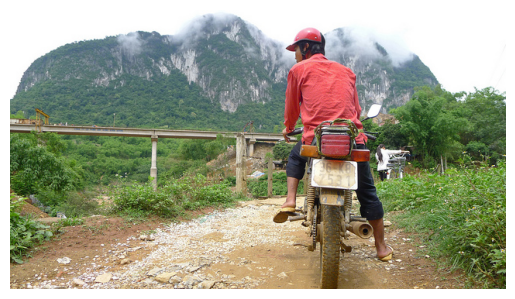

In [23]:
file_name = "COCO_val2014_000000391895.jpg"
img_path = f"dataset/val2014/{file_name}"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [24]:
for img_id, img_path  in test_raw.take(1):
    print("Image ID:", img_id.numpy())
    print("Image path:", img_path.numpy())

Image ID: 523573
Image path: b'dataset/test2014/COCO_test2014_000000523573.jpg'


In [25]:
mobilenet = MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False, # Exclude the classification head
    weights='imagenet',
    pooling=None,
)

mobilenet.trainable=False

In [26]:
tokenizer = TextVectorization(
  max_tokens=VOCABULARY_SIZE,
  standardize=standardize,
  output_sequence_length=50,
  ragged=True
)

In [27]:
tokenizer.adapt(train_raw.map(lambda img_path, caption: caption).batch(1024))

In [28]:
tokenizer.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('a'),
 np.str_('[START]'),
 np.str_('[END]'),
 np.str_('on'),
 np.str_('of'),
 np.str_('the'),
 np.str_('in'),
 np.str_('with')]

In [29]:
t = tokenizer([['a large wooden cat'], ['a table on a hill']])

In [30]:
t

<tf.RaggedTensor [[3, 2, 29, 99, 51, 4], [3, 2, 24, 5, 2, 224, 4]]>

In [31]:
# Setting up data for training
train_ds = load_dataset(TRAIN_DATASET_PATH)

In [33]:
# Sanity check for data loading
train_ds.element_spec

for (inputs, end_token) in train_ds.take(1):
  (img, start_token) = inputs

print(img.shape)
print(start_token.shape)
print(end_token.shape)

print(start_token[0])
print(end_token[0])
print(img[0])

(256, 7, 7, 576)
(256, 30)
(256, 30)
tf.Tensor(
[  3 141 356 449 502   1  13 954   2 420   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
tf.Tensor(
[141 356 449 502   1  13 954   2 420   4   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0], shape=(30,), dtype=int64)
tf.Tensor(
[[[-0.         -0.         -0.19652514 ... -0.         -0.
   -0.        ]
  [-0.         -0.         -0.         ... -0.28157356 -0.
   -0.        ]
  [-0.         -0.         -0.         ... -0.24638106 -0.32692382
   -0.02809549]
  ...
  [-0.          2.8560805  -0.36359307 ... -0.3602001   3.644648
   -0.        ]
  [-0.         -0.2121551  -0.         ...  0.23823453 -0.37323353
   -0.        ]
  [ 0.05304534 -0.35155797 -0.37073305 ... -0.34252498 -0.
   -0.        ]]

 [[ 5.9595914  -0.         -0.         ... -0.14794901 -0.
   -0.        ]
  [12.671749   -0.         -0.3624998  ...  0.15417218  5.6210485
   -0.   

In [34]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

100%|██████████| 1618/1618 [11:10<00:00,  2.41it/s]


Uniform entropy: 9.21
Marginal entropy: 5.41


In [35]:
def masked_loss(labels, preds):
    labels = tf.cast(labels, tf.int32)
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

    mask = (labels != 0) & (loss < 1e8) 
    mask = tf.cast(mask, loss.dtype)

    loss = loss * mask
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss


def masked_acc(labels, preds):
    mask = tf.cast(labels != 0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)

    match = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(match * mask) / tf.reduce_sum(mask)
    return acc

In [36]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path, IMAGE_SHAPE)

In [37]:
loaded_model = Captioner(
    tokenizer, 
    feature_extractor=mobilenet, 
    output_layer=output_layer,
    units=256, 
    dropout_rate=0.2, 
    num_layers=2, 
    num_heads=2
)

loaded_model.compile(optimizer=Adam(learning_rate=0.001), loss=masked_loss, metrics=[masked_acc])

input_shape = ((None, 7, 7, 576), (None, None))  # Example input shapes
loaded_model.build(input_shape)

/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'captioner', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


### I have no idea why, but you need to load in the weights in this order, otherwise it doesn't work: Cell 25, Cell 26, Cell 25 again and Cell 26 again.

In [40]:
loaded_model.load_weights("trained_model/checkpoint_weights.weights.h5")

### Temperature Parameter Modes

The `temperature` parameter allows you to interpolate between three modes:

1. **Greedy Decoding** (`temperature = 0.0`):  
   Chooses the most likely next token at each step.

2. **Random Sampling According to the Logits** (`temperature = 1.0`):  
   Samples tokens based on the predicted probabilities.

3. **Uniform Random Sampling** (`temperature >> 1.0`):  
   Performs nearly uniform sampling, reducing the influence of the model's predictions.

[source](https://www.tensorflow.org/text/tutorials/image_captioning#generate_captions)

In [41]:
for t in (0.0, 0.5, 1.0):
  loaded_result = loaded_model.simple_gen(image, temperature=t)
  print(f"Loadimgimgmmasded_model.result, t={t}: ", loaded_result)
  print("--------")

Loadimgimgmmasded_model.result, t=0.0:  a surfer is riding a wave in the ocean
--------
Loadimgimgmmasded_model.result, t=0.5:  a man is surfing on a wave in the ocean
--------
Loadimgimgmmasded_model.result, t=1.0:  a surfboard is of a man riding a wave
--------


In [88]:
def generate_captions_and_save_to_json(dataset, model, temperature, output_file):
    captions = []

    for img_id, img_path in dataset:
        img_id = img_id.numpy()
        img_path = img_path.numpy().decode("utf-8")
        img = load_image(img_path, IMAGE_SHAPE)

        caption = model.simple_gen(img, temperature)
        captions.append({"image_id": int(img_id), "caption": caption})

    with open(output_file, "w") as f:
        json.dump(captions, f, indent=4)

    print(f"Captions saved to {output_file}")

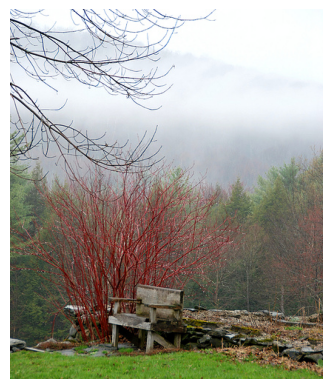

In [34]:
file_name = "COCO_test2014_000000523573.jpg"
img_path = f"dataset/test2014/{file_name}"
img = mpimg.imread(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [28]:
image_test = load_image("dataset/test2014/COCO_test2014_000000523573.jpg", IMAGE_SHAPE)

In [36]:
loaded_model.simple_gen(image_test, temperature=0.5)

'the cows are grazing the grass near a tree'

In [40]:
generate_captions_and_save_to_json(test_raw, loaded_model, 0.5, "captions_test2014_results_temperature_05.json")

Captions saved to captions_test2014_results_temperature_05.json


In [89]:
generate_captions_and_save_to_json(val_raw, loaded_model, 0.5, "captions_val2014_results_temperature_05.json")

Captions saved to captions_val2014_results_temperature_05.json


### Model Evaluation

In [90]:
VAL_CAPTIONS_RESULTS_FILE = "captions_val2014_results_temperature_05.json"

In [91]:
coco_val_res = coco_val.loadRes(VAL_CAPTIONS_RESULTS_FILE)

Loading and preparing results...
DONE (t=0.40s)
creating index...
index created!


In [92]:
coco_val_eval = COCOEvalCap(coco_val, coco_val_res)

In [93]:
# Does not work on WSL, requires Java

coco_val_eval.evaluate()

tokenization...


PTBTokenizer tokenized 2492309 tokens at 2206589.93 tokens per second.
PTBTokenizer tokenized 434027 tokens at 2940502.72 tokens per second.


setting up scorers...
computing Bleu score...
{'testlen': 393524, 'reflen': 389580, 'guess': [393524, 353020, 312517, 272015], 'correct': [236587, 97186, 34677, 12487]}
ratio: 1.0101237229837234
Bleu_1: 0.601
Bleu_2: 0.407
Bleu_3: 0.264
Bleu_4: 0.170
computing METEOR score...
METEOR: 0.190
computing Rouge score...
ROUGE_L: 0.436
computing CIDEr score...
CIDEr: 0.546
computing SPICE score...


Exception in thread "main" java.lang.ExceptionInInitializerError
	at edu.anu.spice.SpiceParser.<init>(SpiceParser.java:178)
	at edu.anu.spice.SpiceScorer.scoreBatch(SpiceScorer.java:70)
	at edu.anu.spice.SpiceScorer.main(SpiceScorer.java:60)
Caused by: java.lang.reflect.InaccessibleObjectException: Unable to make field private final byte[] java.lang.String.value accessible: module java.base does not "opens java.lang" to unnamed module @1ed6993a
	at java.base/java.lang.reflect.AccessibleObject.throwInaccessibleObjectException(AccessibleObject.java:391)
	at java.base/java.lang.reflect.AccessibleObject.checkCanSetAccessible(AccessibleObject.java:367)
	at java.base/java.lang.reflect.AccessibleObject.checkCanSetAccessible(AccessibleObject.java:315)
	at java.base/java.lang.reflect.Field.checkCanSetAccessible(Field.java:183)
	at java.base/java.lang.reflect.Field.setAccessible(Field.java:177)
	at org.nustaq.serialization.FSTClazzInfo.createFieldInfo(FSTClazzInfo.java:499)
	at org.nustaq.serial

CalledProcessError: Command '['java', '-jar', '-Xmx8G', 'spice-1.0.jar', '/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/pycocoevalcap/spice/tmp/tmpd6xtb8ph', '-cache', '/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/pycocoevalcap/spice/cache', '-out', '/home/hylke/miniconda3/envs/imagecaption/lib/python3.10/site-packages/pycocoevalcap/spice/tmp/tmp83s9kl00', '-subset', '-silent']' returned non-zero exit status 1.

In [5]:
TEST_RESULTS_C5_FILE = "results/output/captions_test2014c5_rugtransformer24_eval.json"
TEST_RESULTS_C40_FILE = "results/output/captions_test2014c40_rugtransformer24_eval.json"

In [3]:
def plot_evaluation_metrics(file_c5, file_c40):
    with open(file_c5, 'r') as f:
        data_c5 = json.load(f)
    
    with open(file_c40, 'r') as f:
        data_c40 = json.load(f)

    metrics = list(data_c5.keys())
    scores_c5 = [data_c5[metric] for metric in metrics]
    scores_c40 = [data_c40[metric] for metric in metrics]

    plt.figure(figsize=(10, 5))
    plt.plot(metrics, scores_c5, marker='o', linestyle='-', label='c5 (5 references)')
    plt.plot(metrics, scores_c40, marker='s', linestyle='--', label='c40 (40 references)')

    plt.xlabel("Evaluation Metrics")
    plt.ylabel("Scores")
    plt.title("Comparison of Evaluation Metrics (c5 vs. c40)")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    plt.tight_layout()
    plt.show()

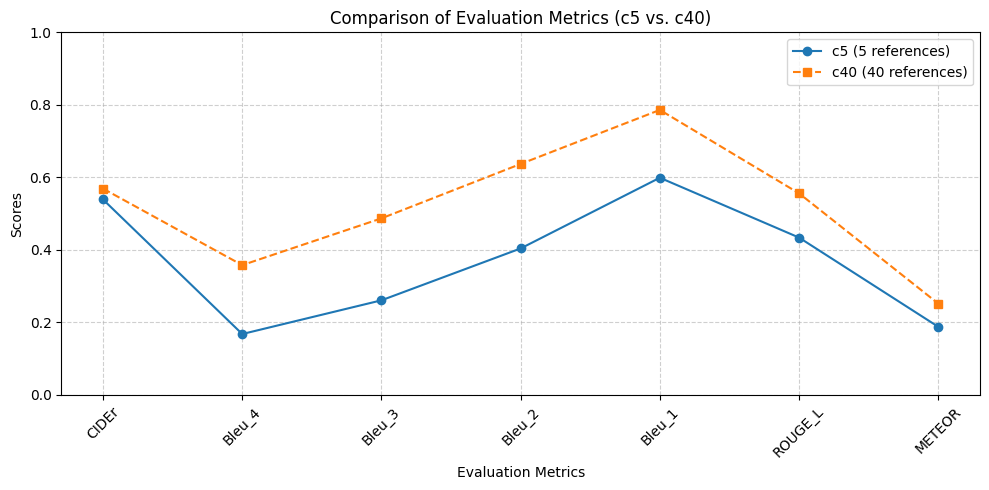

In [10]:
plot_evaluation_metrics(TEST_RESULTS_C5_FILE, TEST_RESULTS_C40_FILE)

In [48]:
def generate_and_display_caption(image_path, model, temperature):
    img = load_image(image_path, IMAGE_SHAPE)

    caption = model.simple_gen(img, temperature)

    img_to_show = mpimg.imread(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_to_show)
    plt.axis("off")
    
    plt.figtext(0.5, 0.02, caption, wrap=True, horizontalalignment='center', fontsize=12)

    plt.show()


In [52]:
for img_id, img_path  in test_raw.take(50):
    print("Image ID:", img_id.numpy())
    print("Image path:", img_path.numpy())

Image ID: 523573
Image path: b'dataset/test2014/COCO_test2014_000000523573.jpg'
Image ID: 347527
Image path: b'dataset/test2014/COCO_test2014_000000347527.jpg'
Image ID: 413171
Image path: b'dataset/test2014/COCO_test2014_000000413171.jpg'
Image ID: 102283
Image path: b'dataset/test2014/COCO_test2014_000000102283.jpg'
Image ID: 296903
Image path: b'dataset/test2014/COCO_test2014_000000296903.jpg'
Image ID: 540552
Image path: b'dataset/test2014/COCO_test2014_000000540552.jpg'
Image ID: 327534
Image path: b'dataset/test2014/COCO_test2014_000000327534.jpg'
Image ID: 159467
Image path: b'dataset/test2014/COCO_test2014_000000159467.jpg'
Image ID: 509990
Image path: b'dataset/test2014/COCO_test2014_000000509990.jpg'
Image ID: 252230
Image path: b'dataset/test2014/COCO_test2014_000000252230.jpg'
Image ID: 104129
Image path: b'dataset/test2014/COCO_test2014_000000104129.jpg'
Image ID: 133861
Image path: b'dataset/test2014/COCO_test2014_000000133861.jpg'
Image ID: 247972
Image path: b'dataset/t

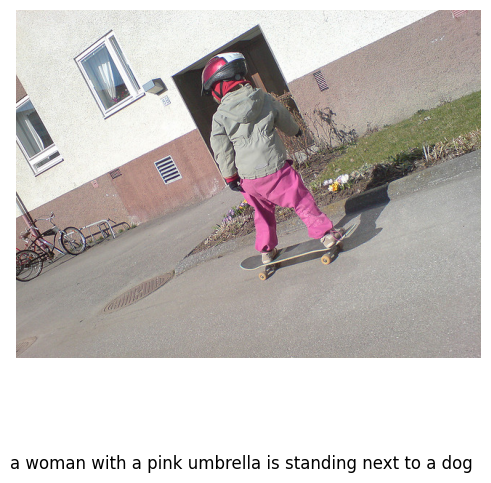

In [67]:
generate_and_display_caption("dataset/test2014/COCO_test2014_000000004638.jpg", loaded_model, 0.5)